# Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn

# Obtenção dos dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)


# PLSR - CROSSVALIDATION

In [5]:
def optimise_pls_cv(X, y, n_comp, plot_components=True, nome_col=None):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
       
    # Mean centering
    X_mean = np.mean(X, axis=0)
    #calcula a media de cada coluna de X
    #subtrai essas médias de X, resultando em dados centralizados em torno de zero
    X -= X_mean
 
    # define the parameter space for the search
    parameters = {'n_components': np.arange(1, n_comp+1, 1)}
    
    # Define the grid-search estimator based on PLS regression
    #gridsearch usa validação cruzada para encontrar os melhores hiperparâmetros de um modelo de aprendizado de máquina
    pls = GridSearchCV(PLSRegression(), parameters, scoring='r2', verbose=1, cv=10)
    
    # Fit the estimator to the data
    pls.fit(X, y)
    
    # Optional: print the best estimator
    print(pls.best_estimator_)
    
    # Apply the best estimator to calculate a cross-validation predicted variable
    y_cv = cross_val_predict(pls.best_estimator_, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    y_c = pls.best_estimator_.predict(X)   # Predicted variable from calibration
    
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    # Calculate root mean squared error for calibration and cross validation
    rmse_c = np.sqrt(mse_c)
    rmse_cv = np.sqrt(mse_cv)

    # Calculate bias for calibration and cross validation
    bias_c = np.mean(y - y_c)
    bias_cv = np.mean(y - y_cv)

    # Calculate RPD for cross validation
    rpd_cv = np.std(y) / rmse_cv
 
    print('R2 calib: %5.6f' % score_c)
    print('RMSE calib: %5.6f' % rmse_c)
    print('Bias calib: %5.6f' % bias_c)
    print('R2 CV: %5.6f' % score_cv)
    print('RMSE CV: %5.6f' % rmse_cv)
    print('Bias CV: %5.6f' % bias_cv)
    print('RPD CV: %5.6f' % rpd_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
    
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        z = np.polyfit(y, y_c, 1)
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title(f'{nome_col}\n$R^{2}$ (CV): {score_cv}')
        plt.xlabel('Predicted')
        plt.ylabel('Measured')
        
        plt.show()

    fig = px.scatter(x=y, y=y_cv.flatten(), trendline="ols", width=600, height=600,\
                labels = {"x":"Measured", "y":"Predicted"})
    fig.show()
 
    return


# PLSR - MSC

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=14)
R2 calib: 0.904113
RMSE calib: 0.775258
Bias calib: -0.000000
R2 CV: 0.791893
RMSE CV: 1.142113
Bias CV: 0.032107
RPD CV: 2.192084


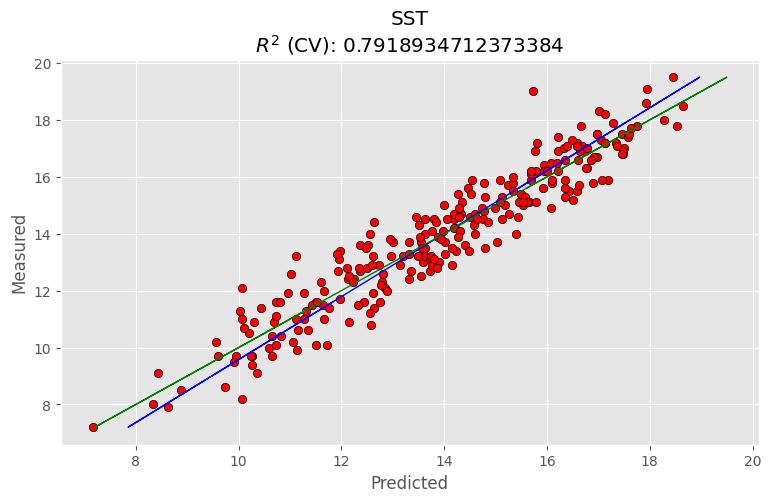

In [6]:
optimise_pls_cv(df_msc.values, df_raw['SST'].values, 40, True, 'SST')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=13)
R2 calib: 0.842732
RMSE calib: 1.166783
Bias calib: 0.000000
R2 CV: 0.711817
RMSE CV: 1.579442
Bias CV: -0.013646
RPD CV: 1.862797


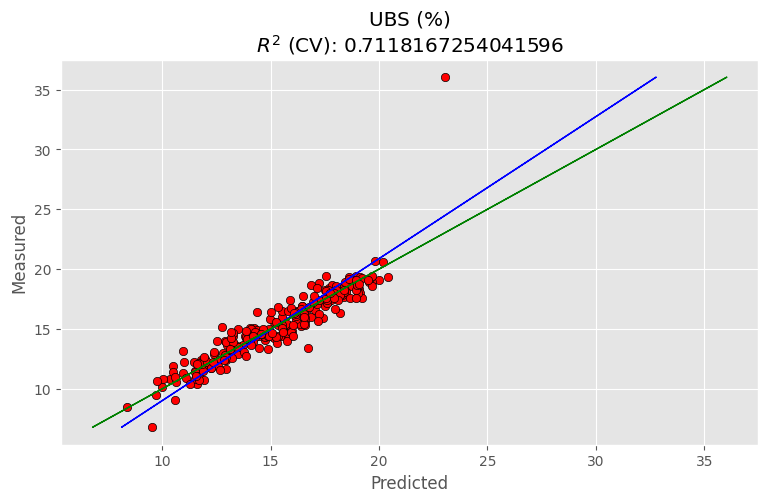

In [49]:
optimise_pls_cv(df_msc.values, df_raw['UBS (%)'].values, 40, True, 'UBS (%)')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=40)
R2 calib: 0.998483
RMSE calib: 0.932616
Bias calib: -0.000000
R2 CV: 0.728373
RMSE CV: 12.478129
Bias CV: 0.288677
RPD CV: 1.918730


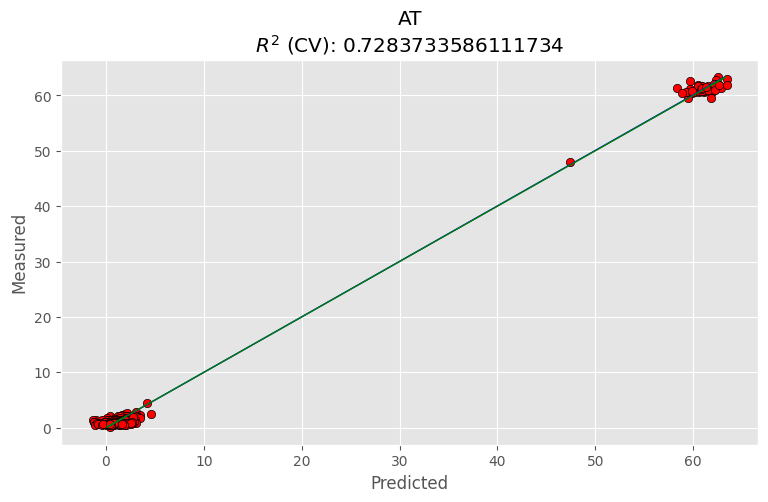

In [50]:
optimise_pls_cv(df_msc.values, df_raw['AT'].values, 40, True, 'AT')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=19)
R2 calib: 0.898457
RMSE calib: 0.085397
Bias calib: 0.000000
R2 CV: 0.478350
RMSE CV: 0.193557
Bias CV: 0.010481
RPD CV: 1.384556


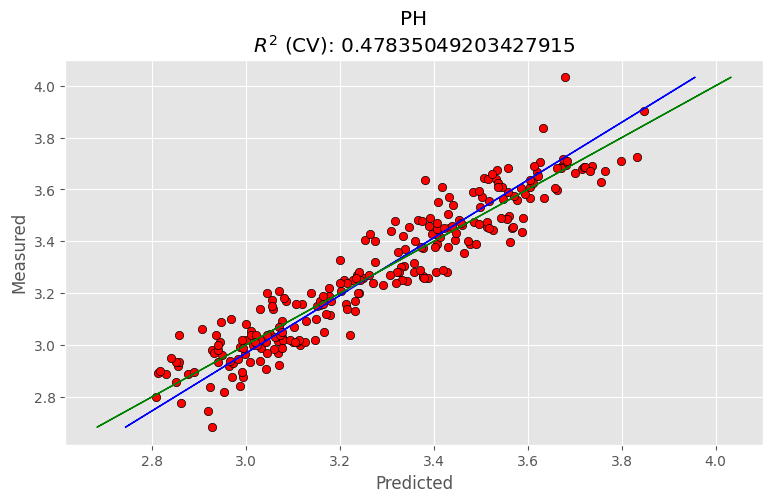

In [51]:
optimise_pls_cv(df_msc.values, df_raw['PH'].values, 40, True, 'PH')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=7)
R2 calib: 0.570358
RMSE calib: 62.898724
Bias calib: -0.000000
R2 CV: 0.440703
RMSE CV: 71.764535
Bias CV: 1.966302
RPD CV: 1.337146


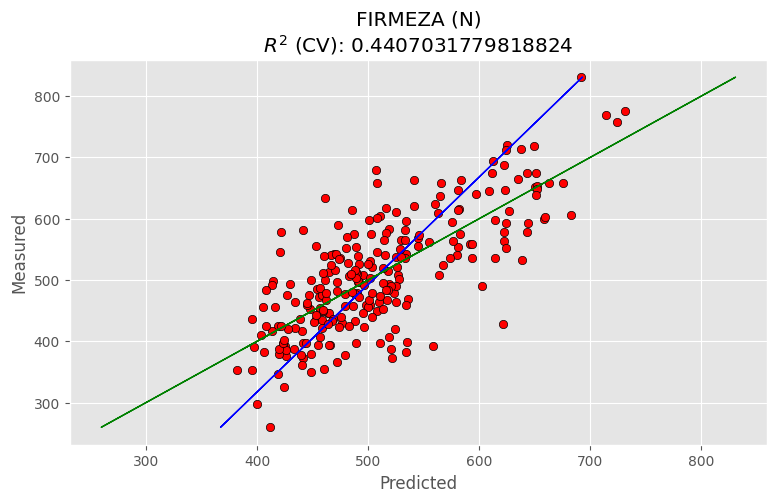

In [52]:
optimise_pls_cv(df_msc.values, df_raw['FIRMEZA (N)'].values, 40, True, 'FIRMEZA (N)')

# PLSR - SNV

Fitting 10 folds for each of 40 candidates, totalling 400 fits


PLSRegression(n_components=14)
R2 calib: 0.893012
RMSE calib: 0.818905
Bias calib: -0.000000
R2 CV: 0.782149
RMSE CV: 1.168547
Bias CV: -0.018573
RPD CV: 2.142496


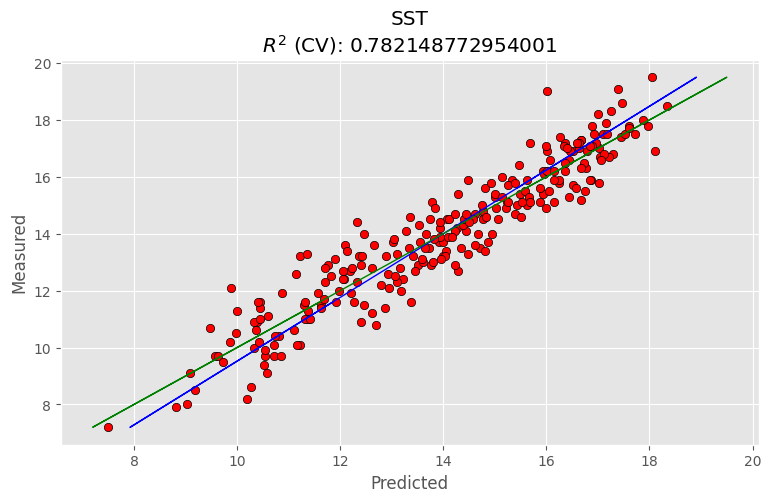

In [53]:
optimise_pls_cv(df_snv.values, df_raw['SST'].values, 40, True, 'SST')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=40)
R2 calib: 0.998182
RMSE calib: 1.020856
Bias calib: -0.000000
R2 CV: 0.728090
RMSE CV: 12.484635
Bias CV: 0.150533
RPD CV: 1.917730


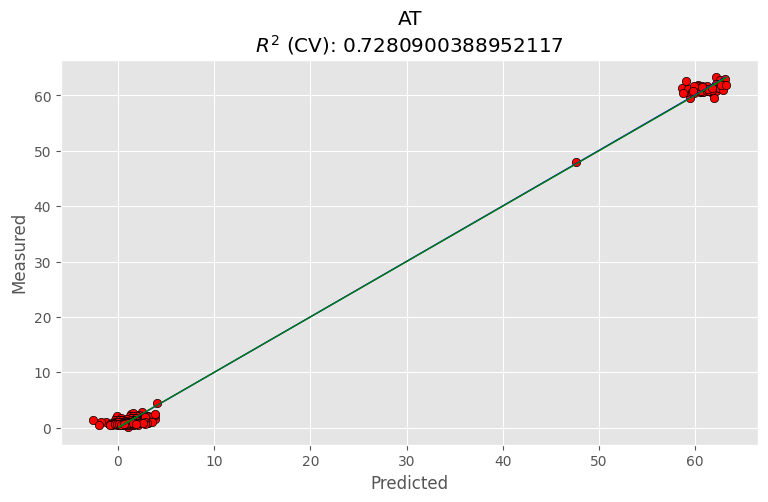

In [54]:
optimise_pls_cv(df_snv.values, df_raw['AT'].values, 40, True, 'AT')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=14)
R2 calib: 0.844115
RMSE calib: 1.161641
Bias calib: 0.000000
R2 CV: 0.707606
RMSE CV: 1.590938
Bias CV: -0.020085
RPD CV: 1.849337


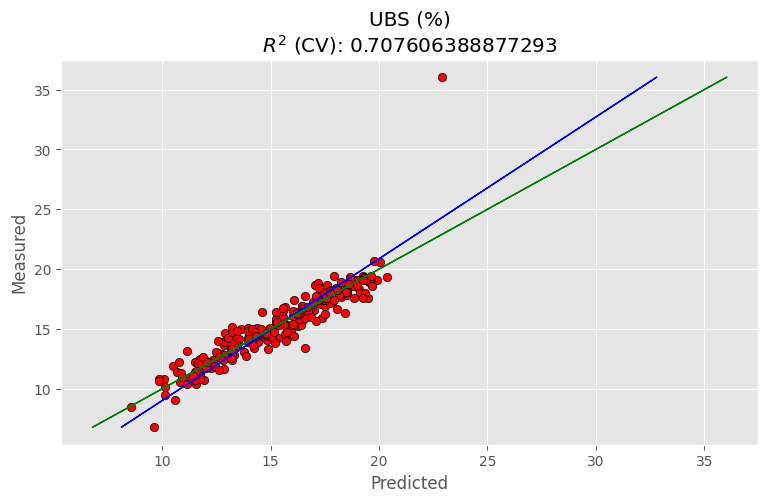

In [55]:
optimise_pls_cv(df_snv.values, df_raw['UBS (%)'].values, 40, True, 'UBS (%)')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=20)
R2 calib: 0.905502
RMSE calib: 0.082382
Bias calib: 0.000000
R2 CV: 0.477668
RMSE CV: 0.193684
Bias CV: 0.011786
RPD CV: 1.383652


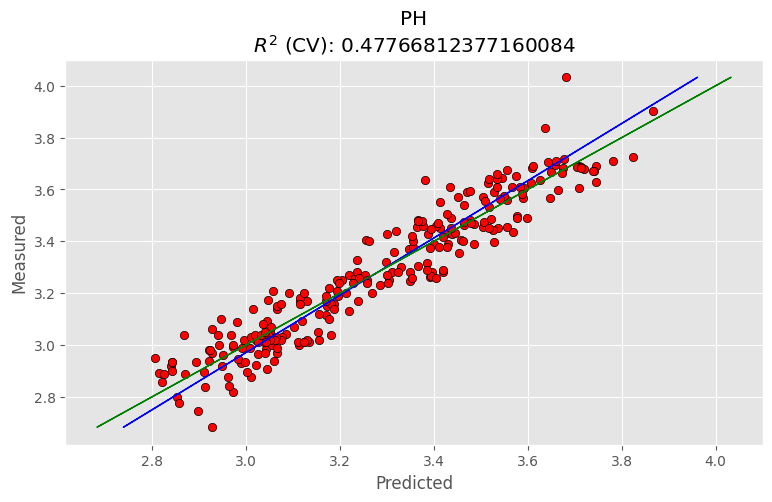

In [56]:
optimise_pls_cv(df_snv.values, df_raw['PH'].values, 40, True, 'PH')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=5)
R2 calib: 0.549046
RMSE calib: 64.439893
Bias calib: -0.000000
R2 CV: 0.459229
RMSE CV: 70.565973
Bias CV: 2.907902
RPD CV: 1.359857


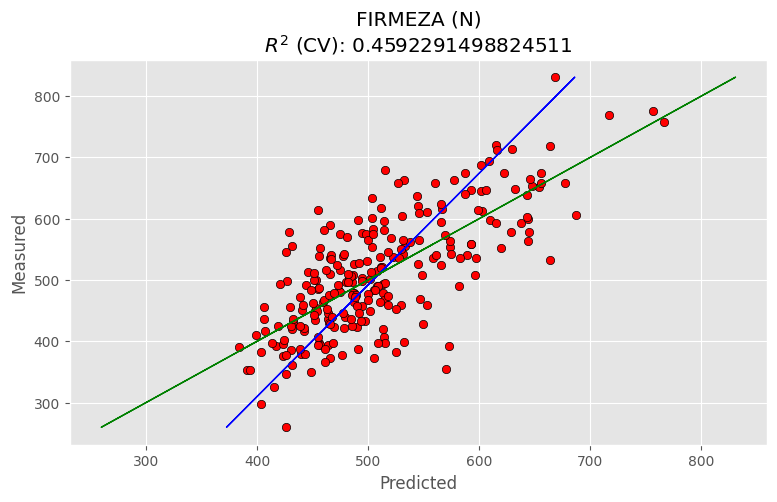

In [57]:
optimise_pls_cv(df_snv.values, df_raw['FIRMEZA (N)'].values, 40, True, 'FIRMEZA (N)')

# PLSR - SAVGOL

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=7)
R2 calib: 0.851283
RMSE calib: 0.965488
Bias calib: -0.000000
R2 CV: 0.760625
RMSE CV: 1.224914
Bias CV: -0.020403
RPD CV: 2.043905


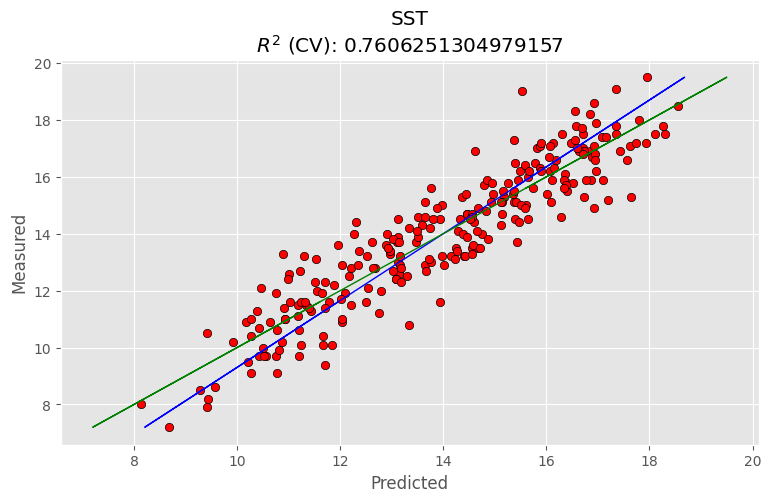

In [58]:
optimise_pls_cv(df_sg.values, df_raw['SST'].values, 40, True, 'SST')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=17)
R2 calib: 0.927661
RMSE calib: 6.439471
Bias calib: -0.000000
R2 CV: 0.630479
RMSE CV: 14.554021
Bias CV: 0.301549
RPD CV: 1.645054


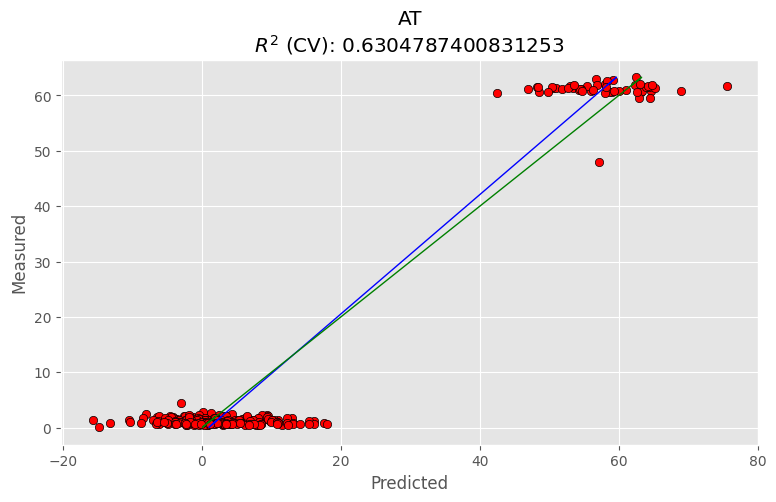

In [59]:
optimise_pls_cv(df_sg.values, df_raw['AT'].values, 40, True, 'AT')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=7)
R2 calib: 0.783073
RMSE calib: 1.370334
Bias calib: 0.000000
R2 CV: 0.675423
RMSE CV: 1.676208
Bias CV: -0.018496
RPD CV: 1.755260


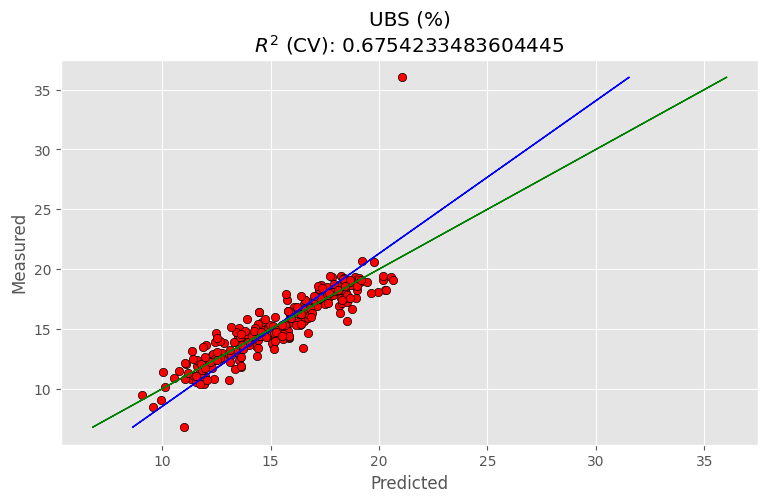

In [60]:
optimise_pls_cv(df_sg.values, df_raw['UBS (%)'].values, 40, True, 'UBS (%)')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=16)
R2 calib: 0.866550
RMSE calib: 0.097899
Bias calib: 0.000000
R2 CV: 0.519017
RMSE CV: 0.185859
Bias CV: 0.014653
RPD CV: 1.441901


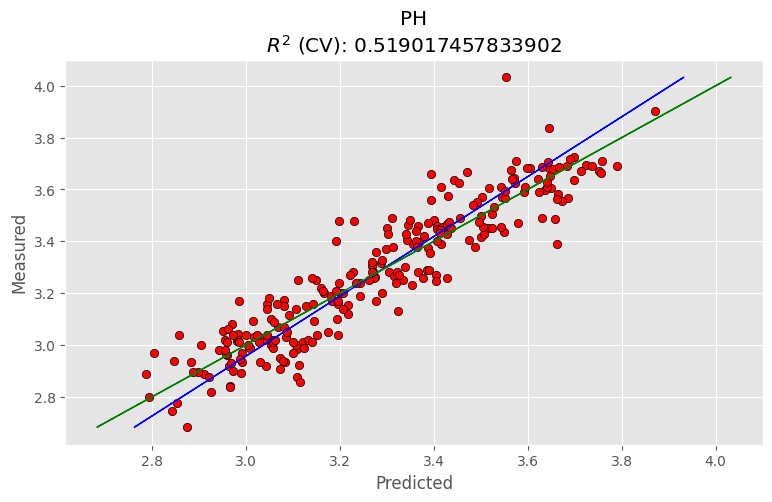

In [61]:
optimise_pls_cv(df_sg.values, df_raw['PH'].values, 40, True, 'PH')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
PLSRegression(n_components=5)
R2 calib: 0.609330
RMSE calib: 59.978233
Bias calib: -0.000000
R2 CV: 0.462222
RMSE CV: 70.370453
Bias CV: 1.311110
RPD CV: 1.363636


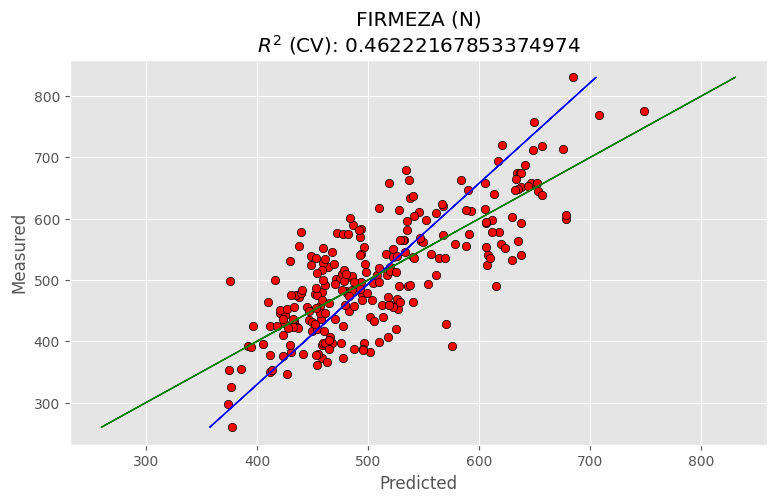

In [62]:
optimise_pls_cv(df_sg.values, df_raw['FIRMEZA (N)'].values, 40, True, 'FIRMEZA (N)')

# PLSR - TRAIN TEST SPLIT

In [70]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Supondo que df_raw, df_msc, df_snv, df_sg sejam seus dataframes definidos anteriormente
X = [df_msc.values, df_snv.values, df_sg.values]
Y = [df_raw['SST'].values, df_raw['AT'].values, df_raw['UBS (%)'].values, df_raw['PH'].values, df_raw['FIRMEZA (N)'].values]

pre_p = ["MSC", "SNV", "Savitzky-Golay"]

results = pd.DataFrame(columns=['Dispositivo', 'Parâmetro', 'Modelo', 'Pré-processamento',
                                'R² Calibração', 'R² Validação', 'RMSE Calibração', 'RMSE Validação'])
index_pr_name = ["SST", "AT", "UBS (%)", "PH", "FIRMEZA (N)"]

results = []

count = 0

# Iteração sobre os dataframes em X e Y
for x_idx, x_df in enumerate(X):
    for y_idx, y_series in enumerate(Y):
        pre = pre_p[x_idx]

        # Define o espaço de parâmetros para a busca
        parameters = {'n_components': np.arange(1, 41, 1)}
        pls = GridSearchCV(PLSRegression(), parameters, scoring='r2', cv=10)
        
        # Dividir dados em conjunto de treino e teste
        x_tr, x_te, y_tr, y_te = train_test_split(x_df, y_series, test_size=0.3, random_state=0)
        
        count += 1
        print(f"Iteration {count}: PLSR for {pre}, x_idx={pre_p[x_idx]}, y_idx={index_pr_name[y_idx]}")

        # Aplicar Grid Search
        pls.fit(x_tr, y_tr)

        # Melhor modelo encontrado pelo Grid Search
        best_pls = pls.best_estimator_

        # Aplicar PLS com o melhor modelo encontrado
        best_pls.fit(x_tr, y_tr)
        y_pred = best_pls.predict(x_te)
        y_cal = best_pls.predict(x_tr)
        
        # Calcular métricas
        r2_cal = r2_score(y_tr, y_cal)
        r2_pred = r2_score(y_te, y_pred)
        rmse_cal = np.sqrt(mean_squared_error(y_tr, y_cal))
        rmse_pred = np.sqrt(mean_squared_error(y_te, y_pred))

        # Armazenar resultados em uma lista de dicionários
        result_row = {
            'Dispositivo': "",
            'Parâmetro': index_pr_name[y_idx],
            'Modelo': "PLSR",
            'Pré-processamento': pre,
            'R² Calibração': f"{r2_cal:.4f}",
            'R² Validação': f"{r2_pred:.4f}",
            'RMSE Calibração': f"{rmse_cal:.4f}",
            'RMSE Validação': f"{rmse_pred:.4f}"
        }
        
        results.append(result_row)

# Converter a lista de dicionários em um DataFrame
results_df = pd.DataFrame(results)


Iteration 1: PLSR for MSC, x_idx=MSC, y_idx=SST
Iteration 2: PLSR for MSC, x_idx=MSC, y_idx=AT
Iteration 3: PLSR for MSC, x_idx=MSC, y_idx=UBS (%)
Iteration 4: PLSR for MSC, x_idx=MSC, y_idx=PH
Iteration 5: PLSR for MSC, x_idx=MSC, y_idx=FIRMEZA (N)
Iteration 6: PLSR for SNV, x_idx=SNV, y_idx=SST
Iteration 7: PLSR for SNV, x_idx=SNV, y_idx=AT
Iteration 8: PLSR for SNV, x_idx=SNV, y_idx=UBS (%)
Iteration 9: PLSR for SNV, x_idx=SNV, y_idx=PH
Iteration 10: PLSR for SNV, x_idx=SNV, y_idx=FIRMEZA (N)
Iteration 11: PLSR for Savitzky-Golay, x_idx=Savitzky-Golay, y_idx=SST
Iteration 12: PLSR for Savitzky-Golay, x_idx=Savitzky-Golay, y_idx=AT
Iteration 13: PLSR for Savitzky-Golay, x_idx=Savitzky-Golay, y_idx=UBS (%)
Iteration 14: PLSR for Savitzky-Golay, x_idx=Savitzky-Golay, y_idx=PH
Iteration 15: PLSR for Savitzky-Golay, x_idx=Savitzky-Golay, y_idx=FIRMEZA (N)


In [71]:
results_df


,Dispositivo,Parâmetro,Modelo,Pré-processamento,R² Calibração,R² Validação,RMSE Calibração,RMSE Validação
0,,SST,PLSR,MSC,0.9163,0.8208,0.7287,1.0408
1,,AT,PLSR,MSC,0.9815,0.8116,3.2789,10.1862
2,,UBS (%),PLSR,MSC,0.6799,0.6751,1.7511,1.4509
3,,PH,PLSR,MSC,0.8345,0.6517,0.1088,0.1588
4,,FIRMEZA (N),PLSR,MSC,0.5165,0.5745,65.0727,65.8542
5,,SST,PLSR,SNV,0.9195,0.8198,0.7147,1.0438
6,,AT,PLSR,SNV,0.9960,0.7642,1.5237,11.3964
7,,UBS (%),PLSR,SNV,0.8462,0.7830,1.2138,1.1858
8,,PH,PLSR,SNV,0.8408,0.6337,0.1067,0.1629
9,,FIRMEZA (N),PLSR,SNV,0.5063,0.6023,65.7548,63.6632


In [92]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
# Encontrar o valor máximo de "RMSE Validação" para ajustar a altura do gráfico
max_y_value = results_df["RMSE Validação"].astype(float).max()
base_height = 300  # Altura base do gráfico
additional_height_per_unit = 20  # Altura adicional por unidade no valor máximo

# Ajustar o número de linhas com base no número de parâmetros
num_parameters = results_df['Parâmetro'].nunique()
row_height = 300  # Altura por linha de faceta
total_height = row_height * num_parameters

# Definir a largura desejada
width = 800  # Largura do gráfico

# Criar uma subplot
fig = make_subplots(
    rows=num_parameters, cols=1,
    shared_xaxes=False,
    vertical_spacing=0.05,
    subplot_titles=[f'Métricas de Resultados para {param}' for param in results_df['Parâmetro'].unique()]
)

# Adicionar cada gráfico ao subplot
for i, param in enumerate(results_df['Parâmetro'].unique()):
    df_param = results_df[results_df['Parâmetro'] == param]
    fig_param = px.bar(
        df_param,
        x="Pré-processamento",
        y="RMSE Validação",
        color="Modelo",
        text_auto=True,
        template='plotly'
    )
    
    for trace in fig_param.data:
        fig.add_trace(trace, row=i+1, col=1)

    # Ajustar o limite do eixo y para a maior barra
    max_y_value_param = df_param["RMSE Validação"].astype(float).max()
    fig.update_yaxes(title_text='RMSE Validação', row=i+1, col=1, range=[0, max_y_value_param + 0.1 * max_y_value_param])

    fig.update_xaxes(tickangle=0, row=i+1, col=1)

# Atualizar layout
fig.update_layout(
    title=dict(text='Métricas de Resultados', font=dict(size=23), yref='paper'),
    height=total_height,  # Ajustar a altura do gráfico
    width=width,  # Ajustar a largura do gráfico
    showlegend=False  # Mostrar a legenda apenas uma vez
)

fig.update_traces(textposition='outside')

fig.show()